In [1]:
import polars as pl
import numpy as np
from numpy import unique
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, 
                             r2_score, 
                             accuracy_score, 
                             confusion_matrix, 
                             classification_report)
import matplotlib.pyplot as plt
import seaborn as sns

df = pl.read_csv('data_neural_network_3det.csv')
df = df.drop('particles_normalized')

In [2]:
#mapper = {
#    'Photon': 0,  # Alterado para começar em 0 para classificação
#    'Proton': 1,
#    'Carbon': 2,
#    'Nitrogen': 3,
#    'Oxygen': 4,
#    'Iron': 5
#}

# Processamento das colunas
trigs = [f"{i}" for i in range(1, 4)]
time_columns = [f"t{i}" for i in range(1, 4)]

#df = df.with_columns([
    #pl.col('composition').map_elements(lambda x: mapper[x], return_dtype=pl.Int64).alias('composition'),
#    pl.col('TRIG').map_elements(lambda x: trigs[x], return_dtype=pl.Int64).alias('TRIG')
#])

# Pivotear os dados
df_neural = df.pivot(
    values=["particles","time"],
    index=["energy", "composition", "simulation_id", "theta", "phi"],  
    on="TRIG",
    aggregate_function=None  
)#.select(["energy", "composition", "simulation_id", "1", "2", "3"])

# Aplicar log10 na energia
df_neural = df_neural.with_columns(pl.col('energy').log10().alias('energy_log'))

df_neural = df_neural.rename({
    **{f"particles_TRIG{i}": str(i) for i in range(1, 4)},
    **{f"time_TRIG{i}": f"t{i}" for i in range(1, 4)}
})
# Log da energia

df_neural = df_neural.select(
    ['energy', 'composition', 'simulation_id', 'theta', 'phi'] + trigs + time_columns
)

min_particle_expr = pl.fold(
    acc=pl.lit(float('inf')),
    function=lambda acc, x: pl.min_horizontal(
        acc,
        pl.when(x > 0).then(x).otherwise(float('inf'))
    ),
    exprs=[pl.col(col) for col in trigs]
).alias("min_particle")
# Menor tempo de detecção > 0
min_time_expr = pl.fold(
    acc=pl.lit(float('inf')),
    function=lambda acc, x: pl.min_horizontal(
        acc,
        pl.when(x > 0).then(x).otherwise(float('inf'))
    ),
    exprs=[pl.col(col) for col in time_columns]
).alias("min_time")

x1 = [0, 800/np.sqrt(3)]
x2 = [-400, -400/np.sqrt(3)]
x3 = [400, -400/np.sqrt(3)]

r1 = (x1[0]**2+x1[1]**2)**0.5
r2 = (x2[0]**2+x2[1]**2)**0.5
r3 = (x3[0]**2+x3[1]**2)**0.5

dist_det = [r1, r2, r3]

distance_exprs = []

df_neural = df_neural.with_columns([
    (np.sin(pl.col("theta"))).alias("theta_sin"),
    (np.cos(pl.col("theta"))).alias("theta_cos"),
    (np.sin(pl.col("phi"))).alias("phi_sin"),
    (np.cos(pl.col("phi"))).alias("phi_cos"),
    pl.max_horizontal(time_columns).alias("max_time"),
    pl.when(min_time_expr == float('inf')).then(None).otherwise(min_time_expr).alias("min_time"),
    #pl.max_horizontal(particle_columns).alias("max_particle"),
    pl.when(min_particle_expr == float('inf')).then(None).otherwise(min_particle_expr).alias("min_particle")
])

for i in range(1, 4):
    dist_val = dist_det[i-1]
    expr = pl.when(
        (pl.col(str(i)) == pl.col("min_particle")) & 
        (pl.col("min_particle") > 0)
    ).then(dist_val).otherwise(float('inf'))
    distance_exprs.append(expr)

#df_neural = df_neural.with_columns([
#    pl.when(pl.min_horizontal(*distance_exprs) == float('inf')).then(None).otherwise(pl.min_horizontal(*distance_exprs)
#    ).alias("min_distance")
#])

for col in trigs:
    df_neural = df_neural.with_columns(pl.col(col).log1p().alias(f"log_{col}"))

log_particle_columns = [f"log_{col}" for col in trigs]


df_neural = df_neural.with_columns(
    pl.concat_list(log_particle_columns).list.mean().alias("mean_particles")
)

df_neural = df_neural.with_columns([
    pl.concat_list(log_particle_columns).list.std().alias("std_particles"),
    pl.concat_list(log_particle_columns).list.max().alias("max_particles"),
    #pl.concat_list(time_columns).list.mean().alias("mean_time"),
    #pl.concat_list(time_columns).list.min().alias("min_time"),
    pl.concat_list(time_columns).list.std().alias("std_time"),
    #pl.concat_list(time_columns).list.max().alias("max_time"),
    #(pl.col("max_particles") / pl.col("mean_particles")).alias("peak_ratio"),
    #(pl.col("max_time") - pl.col("min_time")).alias("time_span")
])

df_neural = df_neural.drop(log_particle_columns)

df_neural

energy,composition,simulation_id,theta,phi,1,2,3,t1,t2,t3,theta_sin,theta_cos,phi_sin,phi_cos,max_time,min_time,min_particle,mean_particles,std_particles,max_particles,std_time
f64,str,i64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0000e15,"""Photon""",847,37.259,5.451,2,6,3,95836.8,95827.3,95844.4,-0.426041,0.904704,-0.739404,0.673262,95844.4,95827.3,2.0,1.476939,0.43086,1.94591,8.567575
1.0000e15,"""Nitrogen""",36,25.93,141.853,4,4,6,132236.0,132236.0,132226.0,0.715444,0.698671,-0.462959,-0.88638,132236.0,132226.0,4.0,1.721595,0.194262,1.94591,5.773503
1.0000e15,"""Carbon""",153,25.005,-161.438,11,18,20,95358.0,95365.4,95354.6,-0.127394,0.991852,0.937986,-0.346673,95365.4,95354.6,11.0,2.824623,0.298428,3.044522,5.522077
3.1600e15,"""Photon""",228,15.905,6.843,624,654,606,94219.5,94215.2,94222.4,-0.195764,-0.980651,0.531029,0.847354,94222.4,94215.2,606.0,6.443639,0.038393,6.484635,3.622614
1.0000e15,"""Photon""",560,16.438,108.59,45,45,54,101729.0,101724.0,101721.0,-0.666897,-0.74515,0.97905,-0.203619,101729.0,101721.0,45.0,3.888205,0.103168,4.007333,4.041452
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3.1600e14,"""Proton""",14,14.34,-137.603,6,4,4,68367.1,68373.2,68368.5,0.9795,-0.201445,0.58678,0.809746,68373.2,68367.1,4.0,1.721595,0.194262,1.94591,3.195309
3.1600e15,"""Photon""",21,33.16,-136.838,95,94,72,106295.0,106310.0,106299.0,0.985025,-0.172411,0.984072,0.17777,106310.0,106295.0,72.0,4.469562,0.155195,4.564348,7.767453
1.0000e15,"""Photon""",180,9.165,18.151,170,179,170,73000.6,72997.4,73001.5,0.256866,-0.966447,-0.643113,0.765772,73001.5,72997.4,170.0,5.158761,0.029614,5.192957,2.15484


In [3]:
df_neural = df_neural.drop(["theta", "phi"])

# Definições do x e do y
remove = ['energy', 'composition', 'simulation_id']

y_energy = df_neural.select('energy').to_numpy()
y_composition = df_neural.select('composition').to_numpy().reshape(-1)
#y_theta = df_neural.select('theta').to_numpy()
#y_phi = df_neural.select('phi').to_numpy()
y_theta_sin = df_neural.select('theta_sin').to_numpy()
y_theta_cos = df_neural.select('theta_cos').to_numpy()
y_phi_sin = df_neural.select('phi_sin').to_numpy()
y_phi_cos = df_neural.select('phi_cos').to_numpy()

y_combined = y_composition.copy()
classes_to_group = ['Carbon', 'Nitrogen', 'Oxygen']
new_class_name = 'CNO'
for i, comp in enumerate(y_combined):
    if comp in classes_to_group:
        y_combined[i] = new_class_name

le = LabelEncoder()
y_composition = le.fit_transform(y_combined)
num_classes = len(unique(y_composition))

# Normalização
scaler_x = StandardScaler()
x = df_neural.select(pl.exclude(remove)).to_numpy()
x_scaled = scaler_x.fit_transform(x)

scaler_y_energy = StandardScaler()
y_energy_scaled = scaler_y_energy.fit_transform(y_energy)

#scaler_y_theta = StandardScaler()
#y_theta_scaled = scaler_y_theta.fit_transform(y_theta)

#scaler_y_phi = StandardScaler()
#y_phi_scaled = scaler_y_phi.fit_transform(y_phi)

y_angles = np.column_stack((
    y_theta_sin, 
    y_theta_cos, 
    y_phi_sin, 
    y_phi_cos
))

# Separação dos dados de treino e teste
#x_train, x_test, y_energy_train, y_energy_test, y_comp_train, y_comp_test, y_theta_train, y_theta_test, y_phi_train, y_phi_test  = train_test_split(
#    x_scaled, y_energy_scaled, y_composition, y_theta_scaled, y_phi_scaled, test_size=0.2
#)

x_train, x_test, y_energy_train, y_energy_test, y_comp_train, y_comp_test, y_angles_train, y_angles_test = train_test_split(
    x_scaled, 
    y_energy_scaled, 
    y_composition, 
    y_angles,  
    test_size=0.2
)

# Conversão para tensores do pytorch
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

y_energy_train_tensor = torch.tensor(y_energy_train, dtype=torch.float32).squeeze(1)
y_energy_test_tensor = torch.tensor(y_energy_test, dtype=torch.float32).squeeze(1)

y_comp_train_tensor = torch.tensor(y_comp_train, dtype=torch.long)
y_comp_test_tensor = torch.tensor(y_comp_test, dtype=torch.long)

y_angles_train_tensor = torch.tensor(y_angles_train, dtype=torch.float32)
y_angles_test_tensor = torch.tensor(y_angles_test, dtype=torch.float32)
#y_theta_train_tensor = torch.tensor(y_theta_train, dtype=torch.float32)
#y_theta_test_tensor = torch.tensor(y_theta_test, dtype=torch.float32)

#y_phi_train_tensor = torch.tensor(y_phi_train, dtype=torch.float32)
#y_phi_test_tensor = torch.tensor(y_phi_test, dtype=torch.float32)

# Para converter para a string das composições

# le.inverse_transform(y_composition)

In [4]:
class MultiTaskModel(nn.Module):
    def __init__(self, input_size, num_classes, dropout_prob=0.3):
        super().__init__()
        #self.shared_layers = nn.Sequential(
        #    nn.Linear(input_size, 256),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_prob),
        #    nn.Linear(256, 128),
        #    nn.Tanh(),
        #    nn.Dropout(dropout_prob),
        #    nn.Linear(128, 64),
        #    nn.Sigmoid()
        #)
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_prob),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_prob),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1)
        )

        # Cabeça de regressão
        self.energy_head = nn.Linear(128, 1)
        #self.theta_head = nn.Linear(64,1)
        #self.phi_head = nn.Linear(64,1)
        self.angle_head = nn.Linear(128, 4)

        # Cabeça de classificação
        #self.composition_head = nn.Sequential(
        #    nn.Linear(64, 64),
        #    nn.ReLU(),
        #    nn.Dropout(0.3),
        #    nn.Linear(64, num_classes)
        #)

        self.composition_head = nn.Sequential(
        nn.Dropout(0.6),  
        nn.Linear(128, 256),
        nn.BatchNorm1d(256),
        nn.GELU(),
        nn.Dropout(0.5),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.GELU(),
        nn.Linear(128, num_classes)
        )
              
    def forward(self, x):
        shared = self.shared_layers(x)
        energy = self.energy_head(shared)
        composition = self.composition_head(shared)
        #theta = self.theta_head(shared)
        #phi = self.phi_head(shared)
        angles = self.angle_head(shared)
        return energy, composition, angles


In [5]:
class ParticleDataset(Dataset):
    def __init__(self, x, y_energy, y_comp, y_angles):
        self.x = x
        self.y_energy = y_energy
        self.y_comp = y_comp
        #self.y_theta = y_theta
        #self.y_phi = y_phi
        self.y_angles = y_angles
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], (self.y_energy[idx], self.y_comp[idx], self.y_angles[idx])#self.y_theta[idx], self.y_phi[idx])

#train_dataset = ParticleDataset(x_train_tensor, y_energy_train_tensor, y_comp_train_tensor, y_theta_train_tensor, y_phi_train_tensor)
#test_dataset = ParticleDataset(x_test_tensor, y_energy_test_tensor, y_comp_test_tensor, y_theta_test_tensor, y_phi_test_tensor)

train_dataset = ParticleDataset(x_train_tensor, y_energy_train_tensor, y_comp_train_tensor, y_angles_train_tensor)
test_dataset = ParticleDataset(x_test_tensor, y_energy_test_tensor, y_comp_test_tensor, y_angles_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [6]:
# Configuração do treino
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskModel(input_size=x_train.shape[1], num_classes=num_classes).to(device)

def components_to_angles(components):
    theta = np.arctan2(components[:, 0], components[:, 1])
    phi = np.arctan2(components[:, 2], components[:, 3])
    return theta, phi

# Função de perda angular personalizada
def angular_loss(pred, target):
    return F.mse_loss(pred, target)

from sklearn.utils.class_weight import compute_class_weight

# Calcular os pesos para cada classe
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_comp_train),  
    y=y_comp_train                   
)

# Converter para tensor e enviar para o dispositivo (GPU/CPU)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Pesos das classes:", class_weights)
print("Classes:", le.classes_)

criterion_energy = nn.MSELoss()
criterion_composition = nn.CrossEntropyLoss()#weight=class_weights)
criterion_angle = nn.MSELoss()

class FocalLoss(nn.Module):
    def __init__(self, alpha=class_weights, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        return torch.mean(self.alpha[targets] * (1-pt)**self.gamma * ce_loss)

criterion_composition = FocalLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)


from torch.optim.lr_scheduler import CosineAnnealingLR

scheduler = CosineAnnealingLR(optimizer, T_max=100)


Pesos das classes: tensor([1.0575, 1.4167, 0.9028, 0.8059], device='cuda:0')
Classes: ['CNO' 'Iron' 'Photon' 'Proton']


In [7]:
def train_model(model, train_loader, test_loader, optimizer, device, epochs=100):
    train_history = {
        'loss': [], 'energy_loss': [], 'comp_loss': [], 'angles_loss': [],
        'energy_r2': [], 'energy_rmse': [], 
        'theta_r2': [], 'theta_rmse': [],
        'phi_r2': [], 'phi_rmse': [],
        'comp_accuracy': []
    }
    test_history = {
        'loss': [], 'energy_loss': [], 'comp_loss': [], 'angles_loss': [],
        'energy_r2': [], 'energy_rmse': [], 
        'theta_r2': [], 'theta_rmse': [],
        'phi_r2': [], 'phi_rmse': [],
        'comp_accuracy': []
    }
    
    # Variáveis para armazenar previsões e rótulos para matriz de confusão
    all_comp_preds = []
    all_comp_true = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_energy_loss = 0
        epoch_comp_loss = 0
        epoch_angles_loss = 0
        
        # Arrays para armazenar todas as previsões e valores reais
        all_energy_pred = []
        all_energy_true = []
        all_angles_pred = []
        all_angles_true = []
        all_comp_pred = []
        all_comp_true = []
        
        for inputs, (energy, comp, angles) in train_loader:
            inputs = inputs.to(device)
            energy = energy.to(device)
            comp = comp.to(device)
            angles = angles.to(device)
            
            optimizer.zero_grad()
            energy_pred, comp_pred, angles_pred = model(inputs)
            
            # Calcular perdas
            loss_energy = criterion_energy(energy_pred.squeeze(), energy)
            loss_comp = criterion_composition(comp_pred, comp)
            loss_angles = angular_loss(angles_pred, angles)
            
            # Balanceamento de tarefas
            total_loss = 0.3 * loss_energy + 0.5 * loss_comp + 0.2 * loss_angles
            
            total_loss.backward()
            optimizer.step()
            
            # Acumular perdas
            epoch_loss += total_loss.item()
            epoch_energy_loss += loss_energy.item()
            epoch_comp_loss += loss_comp.item()
            epoch_angles_loss += loss_angles.item()
            
            # Coletar dados para métricas
            all_energy_pred.append(energy_pred.detach().cpu().numpy())
            all_energy_true.append(energy.detach().cpu().numpy())
            all_angles_pred.append(angles_pred.detach().cpu().numpy())
            all_angles_true.append(angles.detach().cpu().numpy())
            all_comp_pred.append(comp_pred.argmax(dim=1).detach().cpu().numpy())
            all_comp_true.append(comp.detach().cpu().numpy())
        
        # Concatenar todos os batches
        all_energy_pred = np.concatenate(all_energy_pred)
        all_energy_true = np.concatenate(all_energy_true)
        all_angles_pred = np.concatenate(all_angles_pred)
        all_angles_true = np.concatenate(all_angles_true)
        all_comp_pred = np.concatenate(all_comp_pred)
        all_comp_true = np.concatenate(all_comp_true)
        
        # Converter componentes angulares de volta para ângulos
        theta_pred_train, phi_pred_train = components_to_angles(all_angles_pred)
        theta_true_train, phi_true_train = components_to_angles(all_angles_true)
        
        # Calcular métricas de treino
        train_energy_r2 = r2_score(all_energy_true, all_energy_pred)
        train_energy_rmse = np.sqrt(mean_squared_error(all_energy_true, all_energy_pred))
        train_theta_r2 = r2_score(theta_true_train, theta_pred_train)
        train_theta_rmse = np.sqrt(mean_squared_error(theta_true_train, theta_pred_train))
        train_phi_r2 = r2_score(phi_true_train, phi_pred_train)
        train_phi_rmse = np.sqrt(mean_squared_error(phi_true_train, phi_pred_train))
        train_comp_accuracy = accuracy_score(all_comp_true, all_comp_pred)
        
        # Salvar histórico de treino
        train_history['loss'].append(epoch_loss / len(train_loader))
        train_history['energy_loss'].append(epoch_energy_loss / len(train_loader))
        train_history['comp_loss'].append(epoch_comp_loss / len(train_loader))
        train_history['angles_loss'].append(epoch_angles_loss / len(train_loader))
        train_history['energy_r2'].append(train_energy_r2)
        train_history['energy_rmse'].append(train_energy_rmse)
        train_history['theta_r2'].append(train_theta_r2)
        train_history['theta_rmse'].append(train_theta_rmse)
        train_history['phi_r2'].append(train_phi_r2)
        train_history['phi_rmse'].append(train_phi_rmse)
        train_history['comp_accuracy'].append(train_comp_accuracy)
        
        # Avaliação no teste
        model.eval()
        test_loss = 0
        test_energy_loss = 0
        test_comp_loss = 0
        test_angles_loss = 0
        
        # Arrays para armazenar todas as previsões e valores reais (teste)
        test_all_energy_pred = []
        test_all_energy_true = []
        test_all_angles_pred = []
        test_all_angles_true = []
        test_all_comp_pred = []
        test_all_comp_true = []
        
        with torch.no_grad():
            for inputs, (energy, comp, angles) in test_loader:
                inputs = inputs.to(device)
                energy = energy.to(device)
                comp = comp.to(device)
                angles = angles.to(device)
                
                energy_pred, comp_pred, angles_pred = model(inputs)
                
                # Calcular perdas
                loss_energy = criterion_energy(energy_pred.squeeze(), energy)
                loss_comp = criterion_composition(comp_pred, comp)
                loss_angles = angular_loss(angles_pred, angles)
                total_loss = 0.2 * loss_energy + 0.6 * loss_comp + 0.2 * loss_angles
                
                # Acumular perdas
                test_loss += total_loss.item()
                test_energy_loss += loss_energy.item()
                test_comp_loss += loss_comp.item()
                test_angles_loss += loss_angles.item()
                
                # Coletar dados para métricas
                test_all_energy_pred.append(energy_pred.detach().cpu().numpy())
                test_all_energy_true.append(energy.detach().cpu().numpy())
                test_all_angles_pred.append(angles_pred.detach().cpu().numpy())
                test_all_angles_true.append(angles.detach().cpu().numpy())
                
                # Coletar previsões para matriz de confusão
                comp_pred_labels = comp_pred.argmax(dim=1).detach().cpu().numpy()
                test_all_comp_pred.append(comp_pred_labels)
                test_all_comp_true.append(comp.detach().cpu().numpy())
        
        # Concatenar todos os batches
        test_all_energy_pred = np.concatenate(test_all_energy_pred)
        test_all_energy_true = np.concatenate(test_all_energy_true)
        test_all_angles_pred = np.concatenate(test_all_angles_pred)
        test_all_angles_true = np.concatenate(test_all_angles_true)
        test_all_comp_pred = np.concatenate(test_all_comp_pred)
        test_all_comp_true = np.concatenate(test_all_comp_true)
        
        # Armazenar previsões para matriz de confusão (última época)
        if epoch == epochs - 1:
            all_comp_preds = test_all_comp_pred
            all_comp_true = test_all_comp_true
        
        # Converter componentes angulares de volta para ângulos
        theta_pred_test, phi_pred_test = components_to_angles(test_all_angles_pred)
        theta_true_test, phi_true_test = components_to_angles(test_all_angles_true)
        
        # Calcular métricas de teste
        test_energy_r2 = r2_score(test_all_energy_true, test_all_energy_pred)
        test_energy_rmse = np.sqrt(mean_squared_error(test_all_energy_true, test_all_energy_pred))
        test_theta_r2 = r2_score(theta_true_test, theta_pred_test)
        test_theta_rmse = np.sqrt(mean_squared_error(theta_true_test, theta_pred_test))
        test_phi_r2 = r2_score(phi_true_test, phi_pred_test)
        test_phi_rmse = np.sqrt(mean_squared_error(phi_true_test, phi_pred_test))
        test_comp_accuracy = accuracy_score(test_all_comp_true, test_all_comp_pred)
        
        # Salvar histórico de teste
        test_history['loss'].append(test_loss / len(test_loader))
        test_history['energy_loss'].append(test_energy_loss / len(test_loader))
        test_history['comp_loss'].append(test_comp_loss / len(test_loader))
        test_history['angles_loss'].append(test_angles_loss / len(test_loader))
        test_history['energy_r2'].append(test_energy_r2)
        test_history['energy_rmse'].append(test_energy_rmse)
        test_history['theta_r2'].append(test_theta_r2)
        test_history['theta_rmse'].append(test_theta_rmse)
        test_history['phi_r2'].append(test_phi_r2)
        test_history['phi_rmse'].append(test_phi_rmse)
        test_history['comp_accuracy'].append(test_comp_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_history["loss"][-1]:.4f} | Test Loss: {test_history["loss"][-1]:.4f}')
        print(f'Energy - Train R²: {train_energy_r2:.4f}, RMSE: {train_energy_rmse:.4f} | Test R²: {test_energy_r2:.4f}, RMSE: {test_energy_rmse:.4f}')
        print(f'Theta  - Train R²: {train_theta_r2:.4f}, RMSE: {train_theta_rmse:.4f} | Test R²: {test_theta_r2:.4f}, RMSE: {test_theta_rmse:.4f}')
        print(f'Phi    - Train R²: {train_phi_r2:.4f}, RMSE: {train_phi_rmse:.4f} | Test R²: {test_phi_r2:.4f}, RMSE: {test_phi_rmse:.4f}')
        print(f'Comp   - Train Acc: {train_comp_accuracy:.4f} | Test Acc: {test_comp_accuracy:.4f}')
        print('-' * 80)
        
        torch.save(model.state_dict(), 'model_weights.pth')
    
    return train_history, test_history, all_comp_preds, all_comp_true

In [8]:
train_history, test_history, comp_preds, comp_true = train_model(
    model, train_loader, test_loader, optimizer, device, epochs=100
)

Epoch 1/100
Train Loss: 0.6834 | Test Loss: 0.5937
Energy - Train R²: 0.3773, RMSE: 0.7872 | Test R²: 0.5081, RMSE: 0.7082
Theta  - Train R²: -0.2824, RMSE: 2.0600 | Test R²: 0.4098, RMSE: 1.3674
Phi    - Train R²: -0.2081, RMSE: 1.9995 | Test R²: 0.6045, RMSE: 1.1048
Comp   - Train Acc: 0.2714 | Test Acc: 0.3193
--------------------------------------------------------------------------------
Epoch 2/100
Train Loss: 0.5676 | Test Loss: 0.5077
Energy - Train R²: 0.5022, RMSE: 0.7038 | Test R²: 0.5469, RMSE: 0.6797
Theta  - Train R²: 0.4135, RMSE: 1.3931 | Test R²: 0.6743, RMSE: 1.0158
Phi    - Train R²: 0.4280, RMSE: 1.3758 | Test R²: 0.7266, RMSE: 0.9186
Comp   - Train Acc: 0.3052 | Test Acc: 0.3647
--------------------------------------------------------------------------------
Epoch 3/100
Train Loss: 0.5355 | Test Loss: 0.4864
Energy - Train R²: 0.5184, RMSE: 0.6922 | Test R²: 0.5432, RMSE: 0.6825
Theta  - Train R²: 0.5850, RMSE: 1.1719 | Test R²: 0.7580, RMSE: 0.8755
Phi    - Train 

In [9]:
def set_dropout_train(model):
    """Set all dropout layers to training mode and store original states."""
    dropout_states = []
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            dropout_states.append(m.training)
            m.train()
    return dropout_states

def restore_dropout(model, dropout_states):
    """Restore dropout layers to their original states."""
    idx = 0
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train(dropout_states[idx])
            idx += 1

def mc_dropout_predict(model, loader, device, num_samples=30):
    """Perform MC Dropout sampling for uncertainty estimation."""
    model.eval()
    dropout_states = set_dropout_train(model)
    
    # Containers for results
    results = {
        'energy_mean': [], 'energy_std': [],
        'angles_components_mean': [], 'angles_components_std': [],
        'theta_circular_mean': [], 'theta_circular_std': [],
        'phi_circular_mean': [], 'phi_circular_std': [],
        'comp_probs': [], 'entropy': [],
        'energy_true': [], 'comp_true': [], 'angles_true': []
    }
    
    with torch.no_grad():
        for inputs, (energy, comp, angles) in loader:
            inputs = inputs.to(device)
            energy = energy.to(device)
            comp = comp.to(device)
            angles = angles.to(device)
            
            # MC sampling containers for current batch
            energy_samples = []
            angles_samples = []
            comp_samples = []
            
            for _ in range(num_samples):
                e_out, c_out, a_out = model(inputs)
                energy_samples.append(e_out.squeeze().cpu().numpy())
                angles_samples.append(a_out.cpu().numpy())
                comp_samples.append(c_out.cpu().numpy())
            
            # Convert to arrays for vectorized operations
            energy_samples = np.array(energy_samples)
            angles_samples = np.array(angles_samples)
            comp_samples = np.array(comp_samples)
            
            # Energy predictions
            results['energy_mean'].append(energy_samples.mean(axis=0))
            results['energy_std'].append(energy_samples.std(axis=0))
            results['energy_true'].append(energy.cpu().numpy())
            
            # Angle predictions
            angles_mean = angles_samples.mean(axis=0)
            angles_std = angles_samples.std(axis=0)
            results['angles_components_mean'].append(angles_mean)
            results['angles_components_std'].append(angles_std)
            results['angles_true'].append(angles.cpu().numpy())
            
            # Circular statistics for angles
            theta_samples = np.arctan2(angles_samples[..., 0], angles_samples[..., 1])
            phi_samples = np.arctan2(angles_samples[..., 2], angles_samples[..., 3])
            
            theta_circ_mean = np.arctan2(
                np.sin(theta_samples).mean(axis=0),
                np.cos(theta_samples).mean(axis=0)
            )
            R_theta = np.hypot(
                np.sin(theta_samples).mean(axis=0),
                np.cos(theta_samples).mean(axis=0)
            )
            theta_circ_std = np.sqrt(-2 * np.log(R_theta))
            
            phi_circ_mean = np.arctan2(
                np.sin(phi_samples).mean(axis=0),
                np.cos(phi_samples).mean(axis=0)
            )
            R_phi = np.hypot(
                np.sin(phi_samples).mean(axis=0),
                np.cos(phi_samples).mean(axis=0)
            )
            phi_circ_std = np.sqrt(-2 * np.log(R_phi))
            
            results['theta_circular_mean'].append(theta_circ_mean)
            results['theta_circular_std'].append(theta_circ_std)
            results['phi_circular_mean'].append(phi_circ_mean)
            results['phi_circular_std'].append(phi_circ_std)
            
            # Composition predictions
            comp_probs = F.softmax(
                torch.tensor(comp_samples).mean(dim=0), 
                dim=-1
            ).numpy()
            entropy = -np.sum(comp_probs * np.log(comp_probs + 1e-9), axis=1)
            
            results['comp_probs'].append(comp_probs)
            results['entropy'].append(entropy)
            results['comp_true'].append(comp.cpu().numpy())
    
    # Concatenate all batch results
    for key in results:
        if key != 'comp_probs':  # Already list of arrays
            results[key] = np.concatenate(results[key])
        else:
            results[key] = np.vstack(results[key])
    
    restore_dropout(model, dropout_states)
    return results

In [10]:
mc_results = mc_dropout_predict(
    model, 
    test_loader, 
    device, 
    num_samples=100 
)

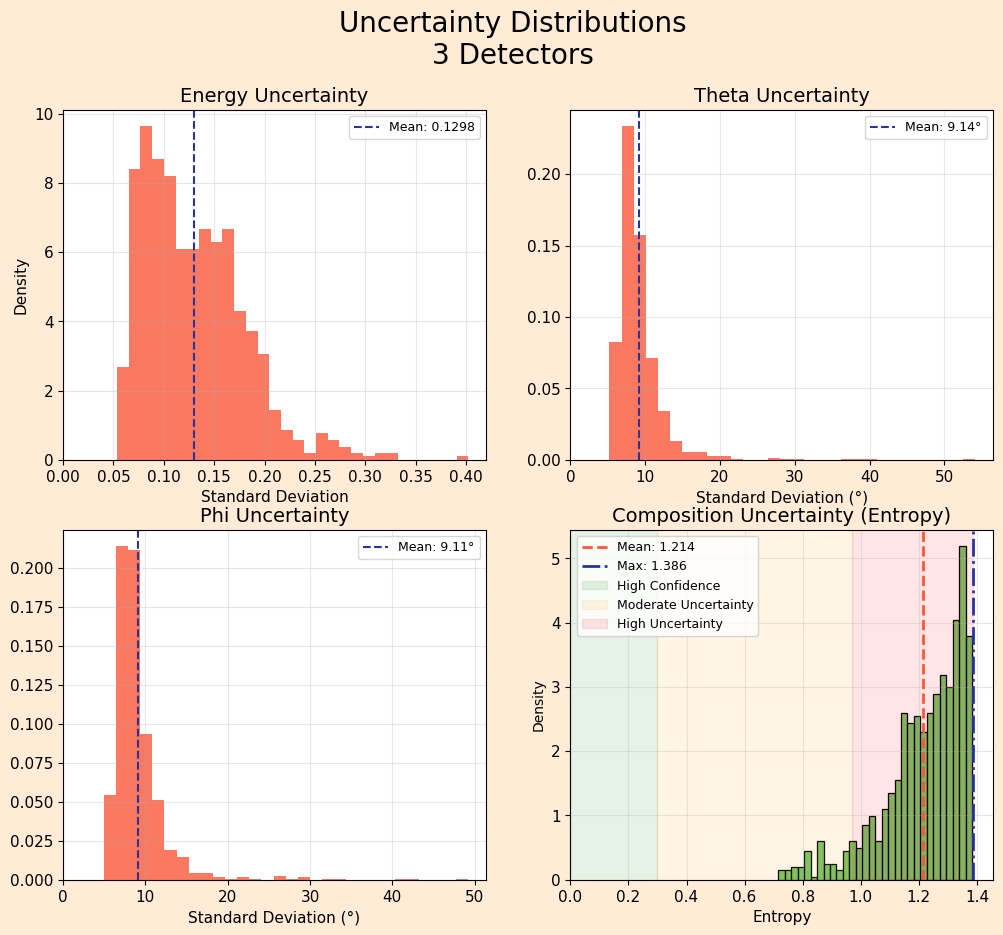

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming we know the number of composition classes
num_classes = mc_results['comp_probs'].shape[1]  # Get from your data
max_entropy = np.log(num_classes)  # Theoretical maximum entropy

# Create figure with beige background
fig = plt.figure(figsize=(12, 10), facecolor='#FFEBD6')
axes = fig.subplots(2, 2).flatten()

# Energy uncertainty
ax0 = axes[0]
ax0.hist(mc_results['energy_std'], bins=30, color='#F95738', density=True, alpha=0.8)
ax0.set_title('Energy Uncertainty', size=14)
ax0.set_xlabel('Standard Deviation', fontsize=11)
ax0.set_ylabel('Density', fontsize=11)
ax0.axvline(np.mean(mc_results['energy_std']), color='#29339B', linestyle='--', 
            label=f'Mean: {np.mean(mc_results["energy_std"]):.4f}')
ax0.legend(fontsize=9)
ax0.set_facecolor('white')  # Set individual plot background to white

# Theta uncertainty
ax1 = axes[1]
theta_std = np.degrees(mc_results['theta_circular_std'])  # Convert to degrees
ax1.hist(theta_std, bins=30, color='#F95738', density=True, alpha=0.8)
ax1.set_title('Theta Uncertainty', size=14)
ax1.set_xlabel('Standard Deviation (°)', fontsize=11)
ax1.axvline(np.mean(theta_std), color='#29339B', linestyle='--', 
            label=f'Mean: {np.mean(theta_std):.2f}°')
ax1.legend(fontsize=9)
ax1.set_facecolor('white')  # Set individual plot background to white

# Phi uncertainty
ax2 = axes[2]
phi_std = np.degrees(mc_results['phi_circular_std'])  # Convert to degrees
ax2.hist(phi_std, bins=30, color='#F95738', density=True, alpha=0.8)
ax2.set_title('Phi Uncertainty', size=14)
ax2.set_xlabel('Standard Deviation (°)', fontsize=11)
ax2.axvline(np.mean(phi_std), color='#29339B', linestyle='--', 
            label=f'Mean: {np.mean(phi_std):.2f}°')
ax2.legend(fontsize=9)
ax2.set_facecolor('white')  # Set individual plot background to white

# Composition entropy (enhanced visualization)
ax3 = axes[3]
entropy = mc_results['entropy']
sns.histplot(entropy, bins=30, kde=False, stat='density',
             color='#54B847', ax=ax3, alpha=0.8)
ax3.set_title('Composition Uncertainty (Entropy)', size=14)
ax3.set_xlabel('Entropy', fontsize=11)
ax3.set_facecolor('white')  # Set individual plot background to white

# Add reference lines and regions
ax3.axvline(entropy.mean(), color='#F95738', linestyle='--', linewidth=2,
            label=f'Mean: {entropy.mean():.3f}')
ax3.axvline(max_entropy, color='#29339B', linestyle='-.', linewidth=2,
            label=f'Max: {max_entropy:.3f}')

# Uncertainty regions
ax3.axvspan(0, 0.3, alpha=0.1, color='green', label='High Confidence')
ax3.axvspan(0.3, max_entropy*0.7, alpha=0.1, color='orange', label='Moderate Uncertainty')
ax3.axvspan(max_entropy*0.7, max_entropy, alpha=0.1, color='red', label='High Uncertainty')

ax3.legend(fontsize=9, loc='upper left')

# Formatting for all subplots
for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=11)
    ax.set_xlim(left=0)
    
    # Add white background to the legend as well
    if ax.get_legend() is not None:
        legend = ax.get_legend()
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)

fig.suptitle('Uncertainty Distributions\n3 Detectors', size=20, y=0.98)
#plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make space for suptitle
plt.savefig('mc_dropout_3det.pdf', bbox_inches='tight', dpi=600, facecolor=fig.get_facecolor())
plt.show()

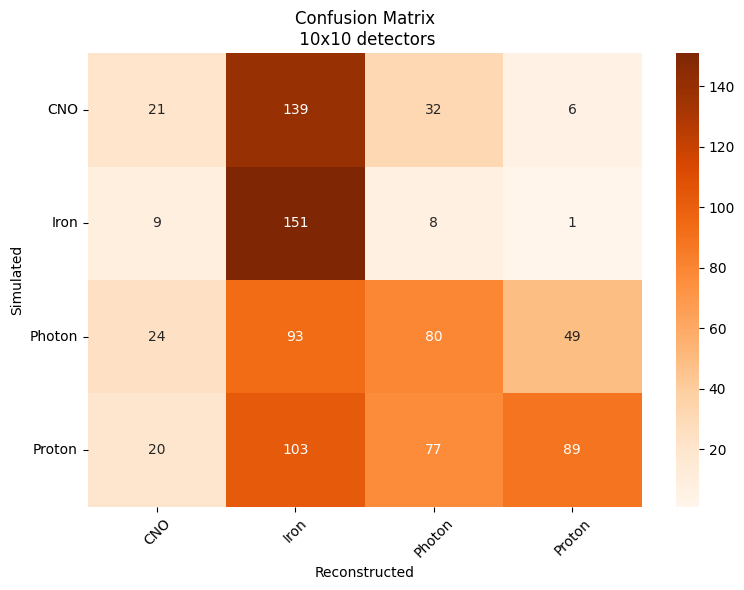


Relatório de Classificação:
              precision    recall  f1-score   support

         CNO       0.28      0.11      0.15       198
        Iron       0.31      0.89      0.46       169
      Photon       0.41      0.33      0.36       246
      Proton       0.61      0.31      0.41       289

    accuracy                           0.38       902
   macro avg       0.40      0.41      0.35       902
weighted avg       0.43      0.38      0.35       902


Acurácia por Classe:
CNO: 0.1061 (198 amostras)
Iron: 0.8935 (169 amostras)
Photon: 0.3252 (246 amostras)
Proton: 0.3080 (289 amostras)


In [46]:
import seaborn as sns
from sklearn.metrics import classification_report
cm = confusion_matrix(comp_true, comp_preds)

# Plotar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix\n 10x10 detectors')
plt.xlabel('Reconstructed')
plt.ylabel('Simulated')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('matrix1_3det.pdf', bbox_inches='tight', dpi=600)
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(
    comp_true, 
    comp_preds, 
    target_names=le.classes_
))

class_accuracy = {}
for i, class_name in enumerate(le.classes_):
    class_idx = np.where(le.transform([class_name])[0] == comp_true)[0]
    correct = np.sum(comp_preds[class_idx] == comp_true[class_idx])
    total = len(class_idx)
    class_accuracy[class_name] = (correct / total, total)

print("\nAcurácia por Classe:")
for class_name, (acc, count) in class_accuracy.items():
    print(f"{class_name}: {acc:.4f} ({count} amostras)")

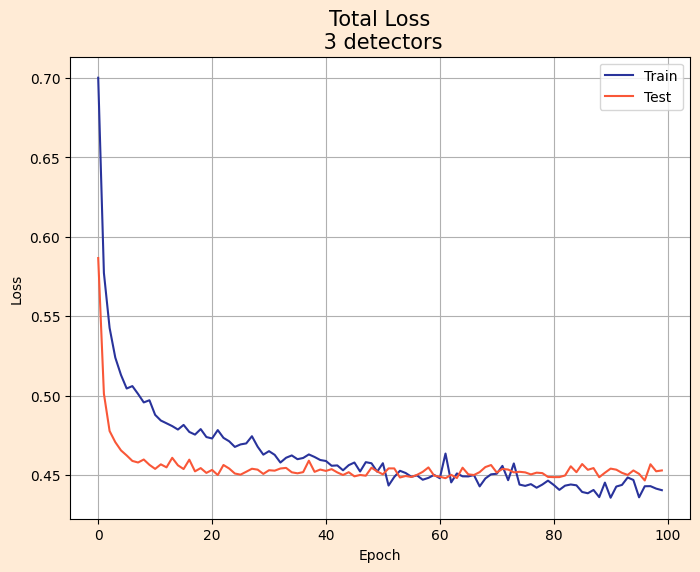

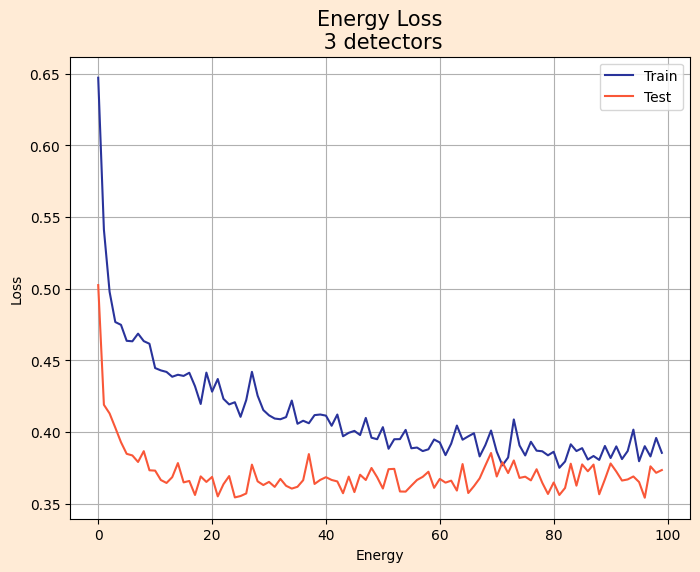

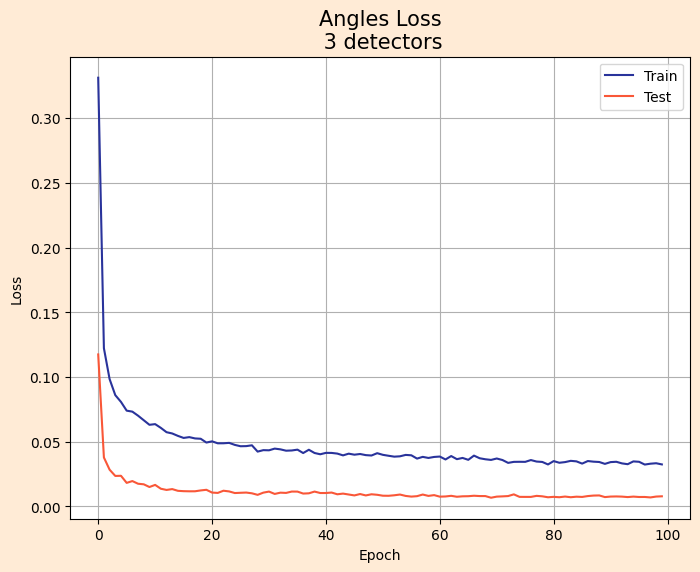

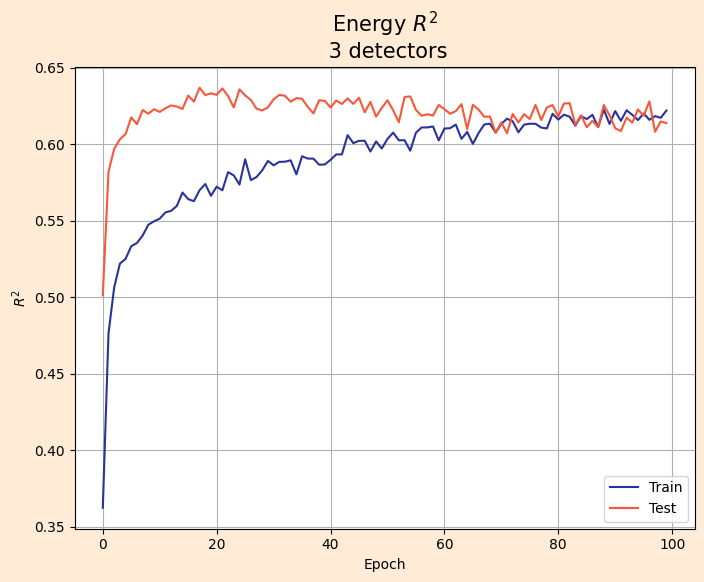

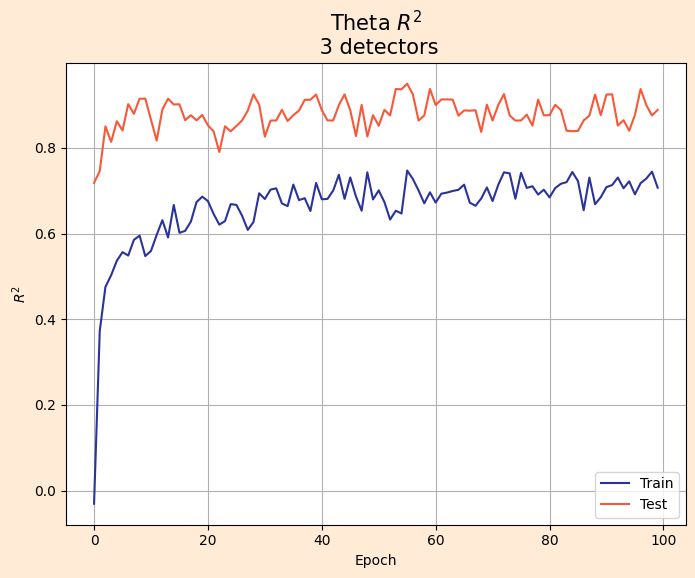

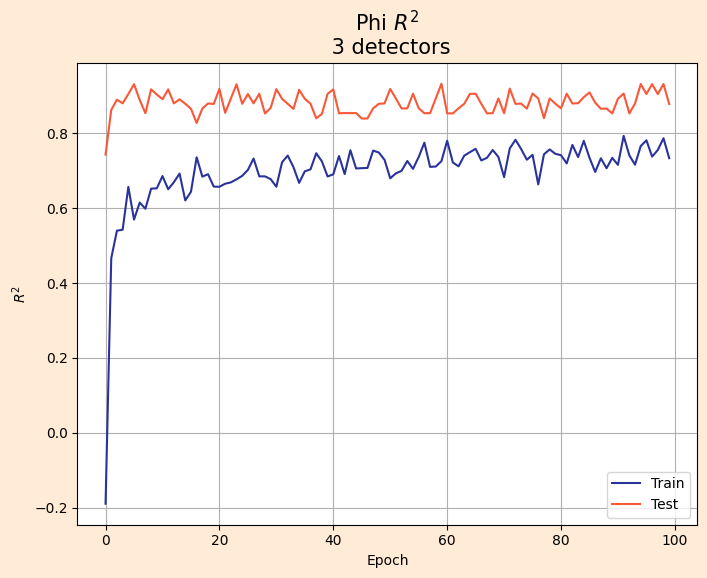

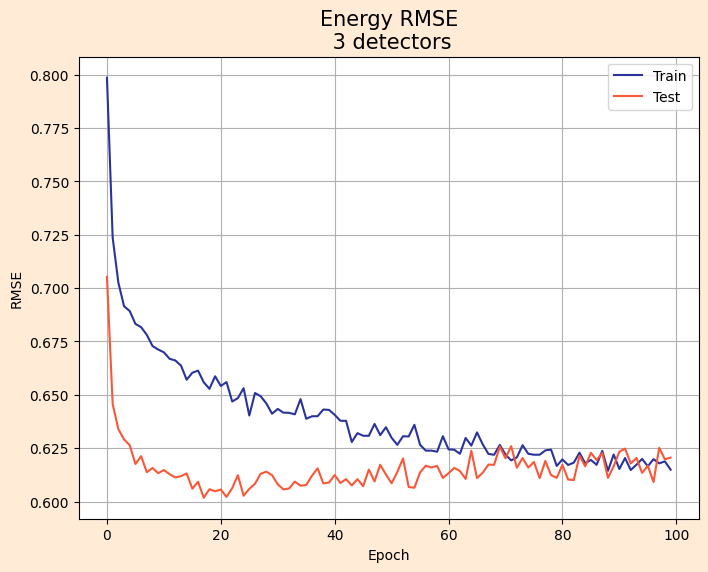

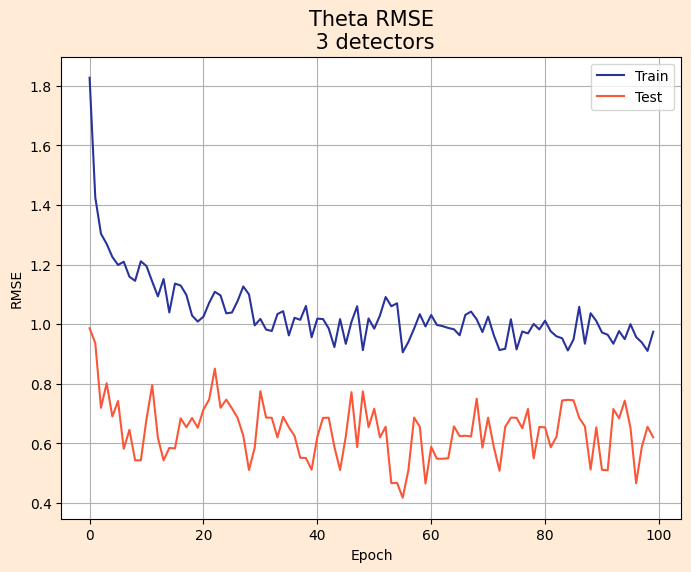

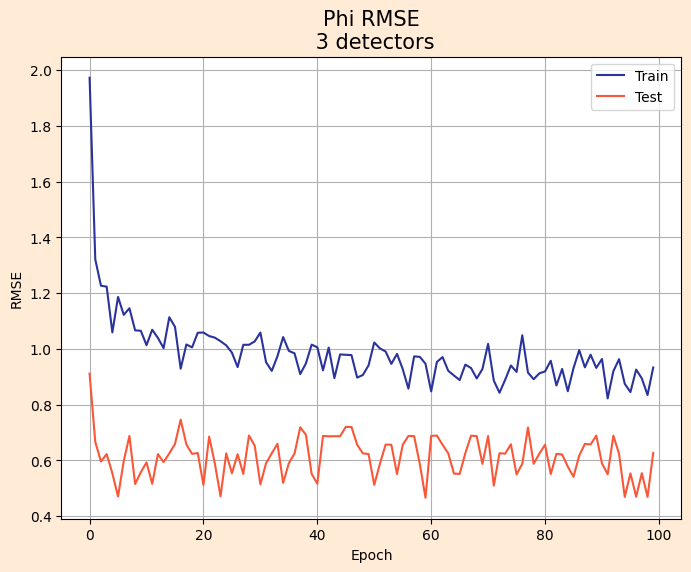

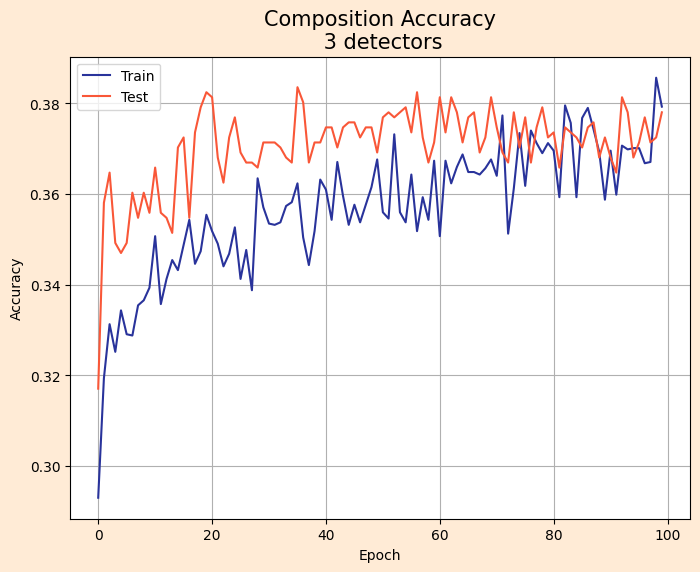

In [47]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor='#FFEBD6')

ax.plot(train_history['loss'], label='Train', color='#29339B') 
ax.plot(test_history['loss'], label='Test', color='#F95738')  

ax.set_title('Total Loss\n 3 detectors', size=15)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

ax.set_facecolor('white')

plt.savefig('loss_plot_3det.pdf', 
            bbox_inches='tight', 
            dpi=600)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#FFEBD6')

ax.plot(train_history['energy_loss'], label='Train', color='#29339B') 
ax.plot(test_history['energy_loss'], label='Test', color='#F95738')  

ax.set_title('Energy Loss\n 3 detectors', size=15)
ax.set_xlabel('Energy')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

ax.set_facecolor('white')

plt.savefig('energy_plot_3det.pdf', 
            bbox_inches='tight', 
            dpi=600)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#FFEBD6')

ax.plot(train_history['angles_loss'], label='Train', color='#29339B') 
ax.plot(test_history['angles_loss'], label='Test', color='#F95738')  

ax.set_title('Angles Loss\n 3 detectors', size=15)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

ax.set_facecolor('white')

plt.savefig('angles_loss_plot_3det.pdf', 
            bbox_inches='tight', 
            dpi=600)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#FFEBD6')

ax.plot(train_history['energy_r2'], label='Train', color='#29339B') 
ax.plot(test_history['energy_r2'], label='Test', color='#F95738')  

ax.set_title('Energy '+ f'$R^2$' + '\n 3 detectors', size=15)
ax.set_xlabel('Epoch')
ax.set_ylabel(f'$R^2$')
ax.legend()
ax.grid(True)

ax.set_facecolor('white')

plt.savefig('energy_r2_3det.pdf', 
            bbox_inches='tight', 
            dpi=600)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#FFEBD6')

ax.plot(train_history['theta_r2'], label='Train', color='#29339B') 
ax.plot(test_history['theta_r2'], label='Test', color='#F95738')  

ax.set_title('Theta '+ f'$R^2$' + '\n 3 detectors', size=15)
ax.set_xlabel('Epoch')
ax.set_ylabel(f'$R^2$')
ax.legend()
ax.grid(True)

ax.set_facecolor('white')

plt.savefig('theta_r2_3det.pdf', 
            bbox_inches='tight', 
            dpi=600)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#FFEBD6')

ax.plot(train_history['phi_r2'], label='Train', color='#29339B') 
ax.plot(test_history['phi_r2'], label='Test', color='#F95738')  

ax.set_title('Phi '+ f'$R^2$' + '\n 3 detectors', size=15)
ax.set_xlabel('Epoch')
ax.set_ylabel(f'$R^2$')
ax.legend()
ax.grid(True)

ax.set_facecolor('white')

plt.savefig('phi_r2_3det.pdf', 
            bbox_inches='tight', 
            dpi=600)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#FFEBD6')

ax.plot(train_history['energy_rmse'], label='Train', color='#29339B') 
ax.plot(test_history['energy_rmse'], label='Test', color='#F95738')  

ax.set_title('Energy RMSE\n 3 detectors', size=15)
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.legend()
ax.grid(True)

ax.set_facecolor('white')

plt.savefig('energy_rmse_3det.pdf', 
            bbox_inches='tight', 
            dpi=600)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#FFEBD6')

ax.plot(train_history['theta_rmse'], label='Train', color='#29339B') 
ax.plot(test_history['theta_rmse'], label='Test', color='#F95738')  

ax.set_title('Theta RMSE\n 3 detectors', size=15)
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.legend()
ax.grid(True)

ax.set_facecolor('white')

plt.savefig('theta_rmse_3det.pdf', 
            bbox_inches='tight', 
            dpi=600)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#FFEBD6')

ax.plot(train_history['phi_rmse'], label='Train', color='#29339B') 
ax.plot(test_history['phi_rmse'], label='Test', color='#F95738')  

ax.set_title('Phi RMSE\n 3 detectors', size=15)
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.legend()
ax.grid(True)

ax.set_facecolor('white')

plt.savefig('phi_rmse_3det.pdf', 
            bbox_inches='tight', 
            dpi=600)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#FFEBD6')

ax.plot(train_history['comp_accuracy'], label='Train', color='#29339B') 
ax.plot(test_history['comp_accuracy'], label='Test', color='#F95738')  

ax.set_title('Composition Accuracy\n 3 detectors', size=15)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True)

ax.set_facecolor('white')

plt.savefig('comp_accuracy_3det.pdf', 
            bbox_inches='tight', 
            dpi=600)

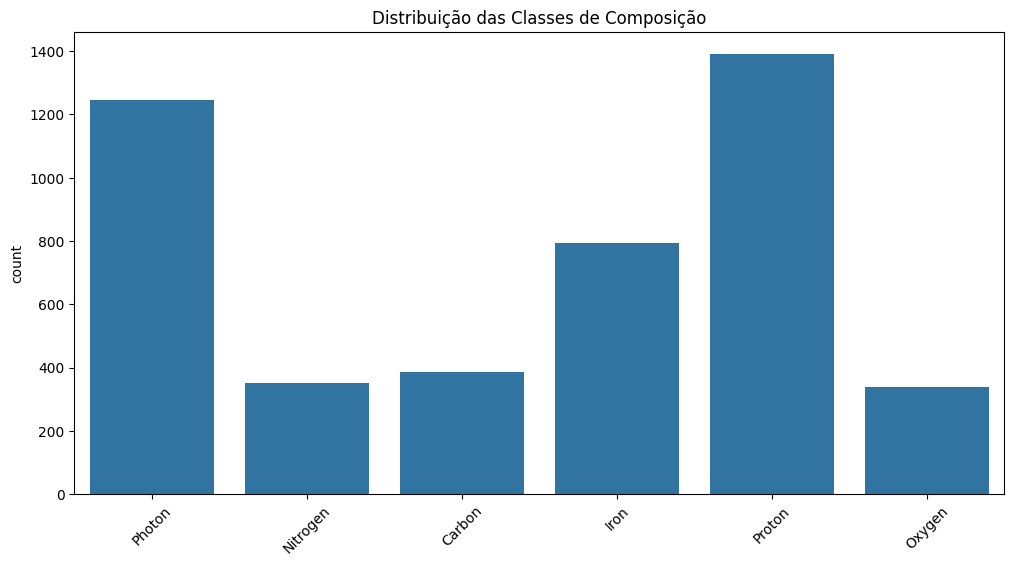


Distribuição antes do balanceamento:
(array(['Carbon', 'Iron', 'Nitrogen', 'Oxygen', 'Photon', 'Proton'],
      dtype=object), array([ 387,  795,  350,  338, 1245, 1391]))

Distribuição após balanceamento:
Classes: [0 1 2 3], Contagens: [1391 1391 1391 1391]


In [19]:
from imblearn.over_sampling import SMOTE

for col in trigs:
    df_neural = df_neural.with_columns(pl.col(col).log1p().alias(f"log_{col}"))

log_particle_columns = [f"log_{col}" for col in trigs]


df_neural = df_neural.with_columns(
    pl.concat_list(log_particle_columns).list.mean().alias("mean_particles")
)

df_neural = df_neural.with_columns([
    pl.concat_list(log_particle_columns).list.std().alias("std_particles"),
    pl.concat_list(log_particle_columns).list.max().alias("max_particles"),
    #pl.concat_list(time_columns).list.mean().alias("mean_time"),
    pl.concat_list(time_columns).list.min().alias("min_time"),
    pl.concat_list(time_columns).list.std().alias("std_time"),
    pl.concat_list(time_columns).list.max().alias("max_time"),
    #(pl.col("max_particles") / pl.col("mean_particles")).alias("peak_ratio"),
    #(pl.col("max_time") - pl.col("min_time")).alias("time_span")
])

df_neural = df_neural.drop(log_particle_columns)
remove = ['energy', 'composition', 'simulation_id', 'theta', 'phi'] #+ particle_columns + time_columns

X = df_neural.select(pl.exclude(remove)).to_numpy()
y = df_neural.select('composition').to_numpy().reshape(-1)

y_combined = y.copy()
classes_to_group = ['Carbon', 'Nitrogen', 'Oxygen']
new_class_name = 'CNO'
for i, comp in enumerate(y_combined):
    if comp in classes_to_group:
        y_combined[i] = new_class_name

le = LabelEncoder()
y_encoded = le.fit_transform(y_combined)
num_classes = len(le.classes_)

plt.figure(figsize=(12, 6))
sns.countplot(x=y)
plt.title('Distribuição das Classes de Composição')
plt.xticks(rotation=45)
plt.show()

print("\nDistribuição antes do balanceamento:")
print(f"{np.unique(y, return_counts=True)}")

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y_encoded)

print("\nDistribuição após balanceamento:")
unique, counts = np.unique(y_res, return_counts=True)
print(f"Classes: {unique}, Contagens: {counts}")

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [21]:
class CompositionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CompositionDataset(X_train_tensor, y_train_tensor)
test_dataset = CompositionDataset(X_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [22]:
class CompositionClassifier(nn.Module):
    def __init__(self, input_size, num_classes, dropout_prob=0.5):
        super(CompositionClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(dropout_prob * 0.7),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CompositionClassifier(input_size=X_train.shape[1], num_classes=num_classes).to(device)

In [23]:
class_counts = np.bincount(y_res)
total_samples = sum(class_counts)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)


C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [24]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=100):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    best_acc = 0.0
    
    for epoch in range(epochs):
        # Treino
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validação
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        test_loss /= len(test_loader)
        test_acc = correct_test / total_test
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        # Atualizar scheduler
        scheduler.step(test_acc)
        
        # Salvar melhor modelo
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_composition_model.pth')
            best_preds = all_preds.copy()
            best_labels = all_labels.copy()
        
        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
              f'Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}')
    
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'best_preds': best_preds,
        'best_labels': best_labels
    }

In [25]:
results = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=100)

Epoch 1/100 | Train Loss: 1.2940, Acc: 0.3831 | Test Loss: 1.2126, Acc: 0.4232
Epoch 2/100 | Train Loss: 1.2351, Acc: 0.4098 | Test Loss: 1.2061, Acc: 0.4349
Epoch 3/100 | Train Loss: 1.2213, Acc: 0.4084 | Test Loss: 1.2071, Acc: 0.4250
Epoch 4/100 | Train Loss: 1.2122, Acc: 0.4159 | Test Loss: 1.1998, Acc: 0.4349
Epoch 5/100 | Train Loss: 1.2010, Acc: 0.4316 | Test Loss: 1.1985, Acc: 0.4394
Epoch 6/100 | Train Loss: 1.1923, Acc: 0.4224 | Test Loss: 1.1990, Acc: 0.4223
Epoch 7/100 | Train Loss: 1.1896, Acc: 0.4388 | Test Loss: 1.1917, Acc: 0.4367
Epoch 8/100 | Train Loss: 1.1864, Acc: 0.4287 | Test Loss: 1.1933, Acc: 0.4322
Epoch 9/100 | Train Loss: 1.1817, Acc: 0.4392 | Test Loss: 1.1922, Acc: 0.4322
Epoch 10/100 | Train Loss: 1.1804, Acc: 0.4404 | Test Loss: 1.1951, Acc: 0.4286
Epoch 11/100 | Train Loss: 1.1866, Acc: 0.4289 | Test Loss: 1.1908, Acc: 0.4223
Epoch 12/100 | Train Loss: 1.1755, Acc: 0.4345 | Test Loss: 1.1896, Acc: 0.4313
Epoch 13/100 | Train Loss: 1.1793, Acc: 0.4372 | 

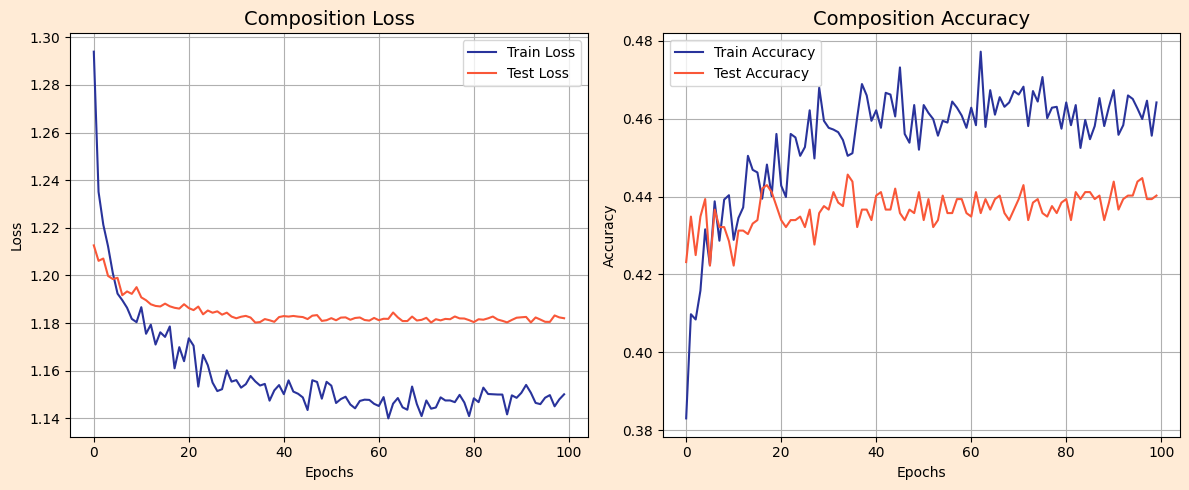

In [26]:
facecolor_fig = '#FFEBD6'  
facecolor_ax = 'white'     
color_train = '#29339B'    
color_test = '#F95738'     

plt.figure(figsize=(12, 5), facecolor=facecolor_fig)

plt.subplot(1, 2, 1)
plt.plot(results['train_losses'], label='Train Loss', color=color_train)
plt.plot(results['test_losses'], label='Test Loss', color=color_test)
plt.title('Composition Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor(facecolor_ax)

plt.subplot(1, 2, 2)
plt.plot(results['train_accs'], label='Train Accuracy', color=color_train)
plt.plot(results['test_accs'], label='Test Accuracy', color=color_test)
plt.title('Composition Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor(facecolor_ax)

# Ajusta layout e salva
plt.tight_layout()

plt.savefig('comp_accuracy2_3det.pdf', 
            bbox_inches='tight', 
            dpi=600,
            facecolor=facecolor_fig)

plt.show()

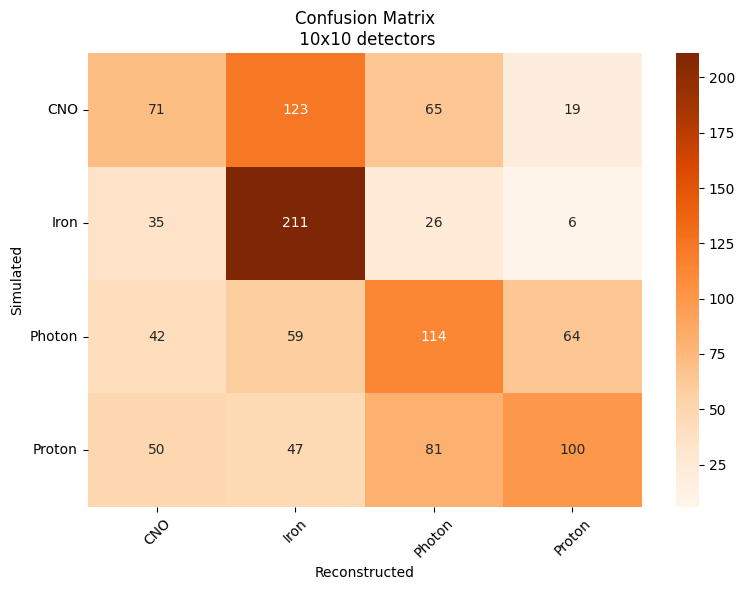


Relatório de Classificação:
              precision    recall  f1-score   support

         CNO       0.36      0.26      0.30       278
        Iron       0.48      0.76      0.59       278
      Photon       0.40      0.41      0.40       279
      Proton       0.53      0.36      0.43       278

    accuracy                           0.45      1113
   macro avg       0.44      0.45      0.43      1113
weighted avg       0.44      0.45      0.43      1113



In [27]:
# Matriz de Confusão
cm = confusion_matrix(results['best_labels'], results['best_preds'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix\n 10x10 detectors')
plt.xlabel('Reconstructed')
plt.ylabel('Simulated')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('matrix2_3det.pdf', bbox_inches='tight', dpi=600)
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(
    results['best_labels'], 
    results['best_preds'], 
    target_names=le.classes_
))

C:\Users\Lucas\AppData\Local\Temp\ipykernel_12320\1080649904.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_composition_model.pt

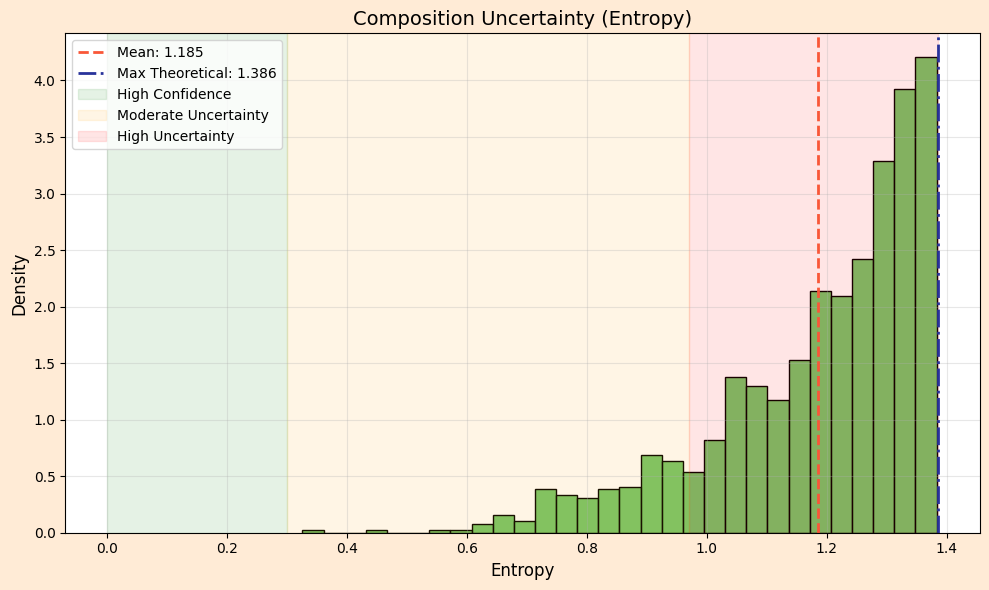

In [29]:
def set_dropout_train(model):
    """Set all dropout layers to training mode and store original states."""
    dropout_states = []
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            dropout_states.append(m.training)
            m.train()
    return dropout_states

def restore_dropout(model, dropout_states):
    """Restore dropout layers to their original states."""
    idx = 0
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train(dropout_states[idx])
            idx += 1

# Função para predições com MC Dropout
def mc_dropout_predict_composition(model, loader, device, num_samples=100):
    """Perform MC Dropout sampling for uncertainty estimation on composition."""
    model.eval()
    dropout_states = set_dropout_train(model)
    
    # Container para probabilidades e entropia
    all_probs = []
    entropy_list = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # MC sampling para o batch atual
            batch_probs = []
            for _ in range(num_samples):
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=-1)
                batch_probs.append(probs.cpu().numpy())
            
            # Converter para array numpy
            batch_probs = np.array(batch_probs)  # [num_samples, batch_size, num_classes]
            
            # Calcular probabilidade média sobre as amostras
            mean_probs = np.mean(batch_probs, axis=0)
            
            # Calcular entropia
            entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-9), axis=1)
            
            all_probs.append(mean_probs)
            entropy_list.append(entropy)
            true_labels.append(labels.cpu().numpy())
    
    # Concatenar resultados
    all_probs = np.concatenate(all_probs, axis=0)
    entropy_list = np.concatenate(entropy_list, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    
    restore_dropout(model, dropout_states)
    return {
        'mean_probs': all_probs,
        'entropy': entropy_list,
        'true_labels': true_labels
    }

# Carregar o melhor modelo
model.load_state_dict(torch.load('best_composition_model.pth'))
model.to(device)

# Obter predições com incerteza usando MC Dropout
mc_results_comp = mc_dropout_predict_composition(
    model, 
    test_loader, 
    device, 
    num_samples=100
)

# Calcular número de classes e entropia máxima teórica
num_classes = mc_results_comp['mean_probs'].shape[1]
max_entropy = np.log(num_classes)

# Criar figura com fundo bege
plt.figure(figsize=(10, 6), facecolor='#FFEBD6')
ax = plt.gca()
ax.set_facecolor('white')  # Fundo do gráfico branco

# Histograma e KDE
sns.histplot(mc_results_comp['entropy'], bins=30, kde=False, stat='density',
             color='#54B847', alpha=0.8)

# Linhas de referência
plt.axvline(mc_results_comp['entropy'].mean(), color='#F95738', linestyle='--', linewidth=2,
            label=f'Mean: {mc_results_comp["entropy"].mean():.3f}')
plt.axvline(max_entropy, color='#29339B', linestyle='-.', linewidth=2,
            label=f'Max Theoretical: {max_entropy:.3f}')

# Regiões de incerteza
plt.axvspan(0, 0.3, alpha=0.1, color='green', label='High Confidence')
plt.axvspan(0.3, max_entropy*0.7, alpha=0.1, color='orange', label='Moderate Uncertainty')
plt.axvspan(max_entropy*0.7, max_entropy, alpha=0.1, color='red', label='High Uncertainty')

# Configurações do gráfico
plt.xlabel('Entropy', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Composition Uncertainty (Entropy)', fontsize=14)
plt.legend(fontsize=10, facecolor='white', framealpha=0.8)
plt.grid(True, alpha=0.3)

# Salvar e mostrar
plt.tight_layout()
plt.savefig('composition_entropy_3det.pdf', bbox_inches='tight', dpi=600, facecolor='#FFEBD6')
plt.show()